In [10]:
# Kaggle Notebook Setup & Initial Imports

import os
import random
import re
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets as torchvision_datasets
from torchvision import transforms, models
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- CIFAR-10 Constants ---
NUM_CLASSES_CIFAR10 = 10
CIFAR10_CLASSES_TUPLE = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Mapping from filename suffix to label index (0-9)
# Example: if 'xxxx.jpg' or 'xxxx (1).jpg' is airplane, 'xxxx (2).jpg' is car
FILENAME_SUFFIX_TO_LABEL = {
    '': 0,          # Assuming 'xxxx.jpg' (no suffix) is the first class
    '(1)': 0,       # Or if (1) is the first class
    '(2)': 1,
    '(3)': 2,
    '(4)': 3,
    '(5)': 4,
    '(6)': 5,
    '(7)': 6,
    '(8)': 7,
    '(9)': 8,
    '(10)': 9,
}
# Create a reverse mapping if needed for class names
LABEL_IDX_TO_NAME = {i: name for i, name in enumerate(CIFAR10_CLASSES_TUPLE)}


# --- Paths ---
CIFAKE_SYNTHETIC_TRAIN_DIR = "/kaggle/input/cifar-10-expr/train/FAKE"

# Real CIFAR-10 for testing the student model
REAL_CIFAR10_ROOT = "./data_cifar10_real"

# --- Hyperparameters ---
BATCH_SIZE = 128 
LEARNING_RATE_STUDENT = 0.05 # DM-KD paper's CIFAR-100 initial LR
KD_TEMPERATURE = 10.0 # DM-KD paper found T=10 to be good
EPOCHS_STUDENT = 50 

# --- Transformations for CIFAR-10 (32x32 images) ---
mean_cifar10 = [0.4914, 0.4822, 0.4465]
std_cifar10  = [0.2023, 0.1994, 0.2010]

transform_cifar_train = transforms.Compose([
    # CIFAKE synthetic images are already 32x32 as per their paper
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cifar10, std=std_cifar10),
])

transform_cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_cifar10, std=std_cifar10),
])

print("Setup Complete. Device:", DEVICE)
print(f"Synthetic CIFAR-10 (CIFAKE FAKE) training directory: {CIFAKE_SYNTHETIC_TRAIN_DIR}")
print(f"Real CIFAR-10 root for testing: {REAL_CIFAR10_ROOT}")

Using device: cuda
Setup Complete. Device: cuda
Synthetic CIFAR-10 (CIFAKE FAKE) training directory: /kaggle/input/cifar-10-expr/train/FAKE
Real CIFAR-10 root for testing: ./data_cifar10_real



Instantiating CIFAKESyntheticDataset...
Loading samples from: /kaggle/input/cifar-10-expr/train/FAKE
Found 50000 image files.


Processing images:   0%|          | 0/50000 [00:00<?, ?it/s]

Successfully loaded 50000 images with labels.
Loaded label distribution:
  Label 0 (airplane): 5000 samples
  Label 1 (automobile): 5000 samples
  Label 2 (bird): 5000 samples
  Label 3 (cat): 5000 samples
  Label 4 (deer): 5000 samples
  Label 5 (dog): 5000 samples
  Label 6 (frog): 5000 samples
  Label 7 (horse): 5000 samples
  Label 8 (ship): 5000 samples
  Label 9 (truck): 5000 samples

Number of samples in synthetic_train_dataset: 50000

Sample 0: Image shape: torch.Size([3, 32, 32]), Label: 5 (dog)

Displaying a few samples from the synthetic dataset...


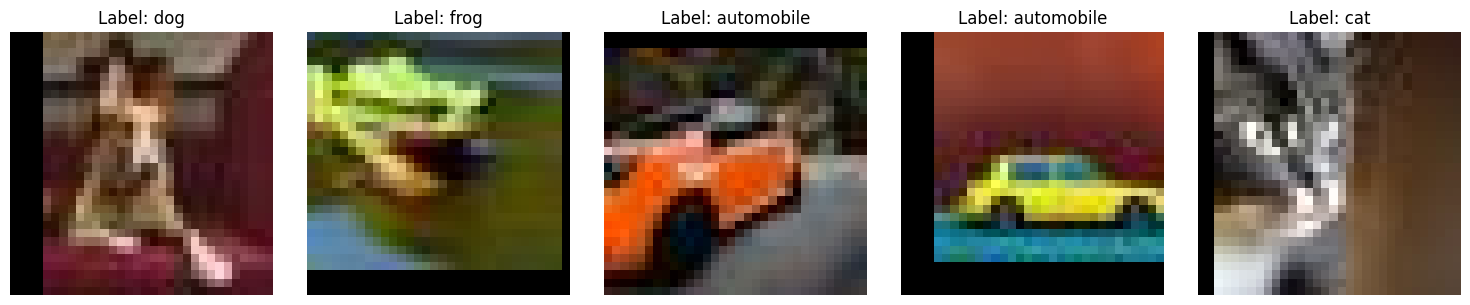


Created DataLoader. One batch example:
Images batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])
First 5 labels in batch: tensor([2, 4, 9, 7, 7])


In [2]:
# Step 1: Custom Dataset Class for CIFAKE Synthetic Data

import os
import re
from glob import glob
from PIL import Image
from torch.utils.data import Dataset

class CIFAKESyntheticDataset(Dataset):
    def __init__(self, root_dir, class_map, filename_to_label_map, transform=None):
        """
        Args:
            root_dir (string): Directory with all the synthetic images (e.g., .../train/FAKE).
            class_map (tuple): Tuple of class names in order (e.g., ('airplane', 'automobile', ...)).
                               This is mainly for reference or potential future use.
            filename_to_label_map (dict): Maps filename suffixes like '(2)' to integer labels 0-9.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.class_map = class_map # For reference
        self.filename_to_label_map = filename_to_label_map
        
        self.image_paths = []
        self.labels = []

        # Regex to capture the base filename and the optional class suffix like (2), (3), etc.
        # It looks for:
        #   - start of string (^)
        #   - one or more digits (\d+)
        #   - optionally, a space followed by parentheses containing digits ( \(\d+\))?
        #   - an image extension like .png, .jpg, .jpeg
        self.filename_pattern = re.compile(r"^\d+(?: \((?P<suffix_num>\d+)\))?\.(png|jpg|jpeg)$", re.IGNORECASE)
        
        self._load_samples()

    def _load_samples(self):
        print(f"Loading samples from: {self.root_dir}")
        if not os.path.isdir(self.root_dir):
            raise ValueError(f"Root directory not found: {self.root_dir}")

        image_files = glob(os.path.join(self.root_dir, "*.[jp][pn]g"))
        print(f"Found {len(image_files)} image files.")
        
        if not image_files:
            print(f"Warning: No image files found in {self.root_dir}. Check the path and file extensions.")
            return

        for img_path in tqdm(image_files, desc="Processing images"):
            filename = os.path.basename(img_path)
            match = self.filename_pattern.match(filename)
            
            if match:
                suffix_num_str = match.group('suffix_num')
                
                # Construct the key for filename_to_label_map
                # If suffix_num_str is None (e.g., filename is '0000.jpg'), it's class 0 ('airplane')
                # If suffix_num_str is '2' (e.g., '0000 (2).jpg'), it's class 1 ('automobile')
                if suffix_num_str is None:
                    label_key = ''
                else:
                    label_key = f"({suffix_num_str})"

                if label_key in self.filename_to_label_map:
                    label = self.filename_to_label_map[label_key]
                    self.image_paths.append(img_path)
                    self.labels.append(label)
                else:
                    print(f"Warning: Could not map filename suffix '{label_key}' from '{filename}' to a label. Skipping.")
            else:
                print(f"Warning: Filename '{filename}' did not match expected pattern. Skipping.")
        
        if not self.image_paths:
            print("CRITICAL WARNING: No images were successfully processed and added to the dataset. "
                  "Please check filename patterns, directory structure, and the FILENAME_SUFFIX_TO_LABEL map in Step 0.")
        else:
            print(f"Successfully loaded {len(self.image_paths)} images with labels.")
            # Print label distribution for verification
            unique_labels, counts = np.unique(self.labels, return_counts=True)
            print("Loaded label distribution:")
            for l, c in zip(unique_labels, counts):
                class_name = self.class_map[l] if l < len(self.class_map) else "Unknown Label"
                print(f"  Label {l} ({class_name}): {c} samples")


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# --- Let's test the Dataset Class ---

# Adjust FILENAME_SUFFIX_TO_LABEL
FILENAME_SUFFIX_TO_LABEL_STRICT = { 

}


# So, the map should be:
# This map is critical and must be accurate.
FILENAME_SUFFIX_TO_LABEL_ADJUSTED = {
    '': 0,         # For 'xxxx.jpg' (airplane)
    '(2)': 1,      # For 'xxxx (2).jpg' (car)
    '(3)': 2,      # For 'xxxx (3).jpg' (bird)
    '(4)': 3,
    '(5)': 4,
    '(6)': 5,
    '(7)': 6,
    '(8)': 7,
    '(9)': 8,
    '(10)': 9,
}

# Test instantiation
print("\nInstantiating CIFAKESyntheticDataset...")
synthetic_train_dataset = CIFAKESyntheticDataset(
    root_dir=CIFAKE_SYNTHETIC_TRAIN_DIR,
    class_map=CIFAR10_CLASSES_TUPLE,
    filename_to_label_map=FILENAME_SUFFIX_TO_LABEL,
    transform=transform_cifar_train
)

# Check dataset length
print(f"\nNumber of samples in synthetic_train_dataset: {len(synthetic_train_dataset)}")

# Get a sample
if len(synthetic_train_dataset) > 0:
    img, label = synthetic_train_dataset[0]
    print(f"\nSample 0: Image shape: {img.shape}, Label: {label} ({CIFAR10_CLASSES_TUPLE[label]})")
    
    # Visualize a few samples
    def imshow(img_tensor, title=""):
        img_tensor = img_tensor.cpu()
        mean = torch.tensor(mean_cifar10).view(3, 1, 1)
        std = torch.tensor(std_cifar10).view(3, 1, 1)
        img_tensor = img_tensor * std + mean # Unnormalize
        npimg = img_tensor.numpy()
        plt.figure(figsize=(4,4))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(title)
        plt.axis('off')
        plt.show()

    print("\nDisplaying a few samples from the synthetic dataset...")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        if i < len(synthetic_train_dataset):
            img, label_idx = synthetic_train_dataset[i * (len(synthetic_train_dataset) // 5)]
            
            # Unnormalize for display
            unnorm_img = img.cpu() * torch.tensor(std_cifar10).view(3,1,1) + torch.tensor(mean_cifar10).view(3,1,1)
            unnorm_img = np.clip(unnorm_img.permute(1, 2, 0).numpy(), 0, 1)
            
            axes[i].imshow(unnorm_img)
            axes[i].set_title(f"Label: {CIFAR10_CLASSES_TUPLE[label_idx]}")
            axes[i].axis("off")
    plt.tight_layout()
    plt.show()
    
    synthetic_train_loader = DataLoader(synthetic_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    print(f"\nCreated DataLoader. One batch example:")
    try:
        dataiter = iter(synthetic_train_loader)
        images, labels = next(dataiter)
        print(f"Images batch shape: {images.shape}")
        print(f"Labels batch shape: {labels.shape}")
        print(f"First 5 labels in batch: {labels[:5]}")
    except Exception as e:
        print(f"Error creating or iterating DataLoader: {e}")
        if len(synthetic_train_dataset) == 0:
             print("This error is likely because the dataset is empty. Please check the _load_samples method and paths.")

else:
    print("\nSynthetic dataset is empty. Cannot display samples or create DataLoader.")


Loading REAL CIFAR-10 test set from/to: ./data_cifar10_real
Files already downloaded and verified
Successfully loaded REAL CIFAR-10 test set.
Number of samples in real_cifar10_test_dataset: 10000

One batch example from REAL CIFAR-10 test loader:
Real images batch shape: torch.Size([128, 3, 32, 32])
Real labels batch shape: torch.Size([128])
First 5 real labels in batch: tensor([3, 8, 8, 0, 6])

Displaying a few samples from the REAL CIFAR-10 test dataset...


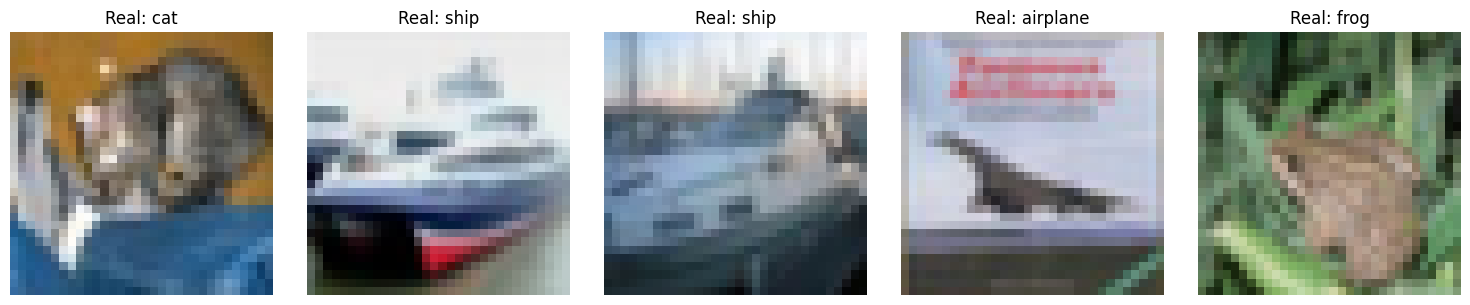

In [12]:
# Step 2: Prepare Real CIFAR-10 Test Loader

print(f"\nLoading REAL CIFAR-10 test set from/to: {REAL_CIFAR10_ROOT}")

try:
    real_cifar10_test_dataset = torchvision_datasets.CIFAR10(
        root=REAL_CIFAR10_ROOT,
        train=False,
        download=True, # If not present
        transform=transform_cifar_test
    )
    
    real_cifar10_test_loader = DataLoader(
        real_cifar10_test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    print(f"Successfully loaded REAL CIFAR-10 test set.")
    print(f"Number of samples in real_cifar10_test_dataset: {len(real_cifar10_test_dataset)}")

    # Verify a batch
    print(f"\nOne batch example from REAL CIFAR-10 test loader:")
    dataiter_real_test = iter(real_cifar10_test_loader)
    images_real, labels_real = next(dataiter_real_test)
    print(f"Real images batch shape: {images_real.shape}")
    print(f"Real labels batch shape: {labels_real.shape}")
    print(f"First 5 real labels in batch: {labels_real[:5]}")

    # Optional: Visualize a few real images from the test set
    print("\nDisplaying a few samples from the REAL CIFAR-10 test dataset...")
    fig_real, axes_real = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        if i < len(images_real): # Display from the fetched batch
            img_real_display = images_real[i]
            label_idx_real = labels_real[i].item()
            
            # Unnormalize for display
            unnorm_img_real = img_real_display.cpu() * torch.tensor(std_cifar10).view(3,1,1) + torch.tensor(mean_cifar10).view(3,1,1)
            unnorm_img_real = np.clip(unnorm_img_real.permute(1, 2, 0).numpy(), 0, 1)
            
            axes_real[i].imshow(unnorm_img_real)
            axes_real[i].set_title(f"Real: {CIFAR10_CLASSES_TUPLE[label_idx_real]}")
            axes_real[i].axis("off")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"ERROR loading real CIFAR-10 test set: {e}")
    print("Please ensure you have internet connectivity in your Kaggle notebook if downloading for the first time.")
    print("If it's a path issue, check the REAL_CIFAR10_ROOT.")

In [3]:
# Step 3.A: Fine-tune the ImageNet Pre-trained Teacher on Real CIFAR-10 Data

print("\n--- Step 3.A: Fine-tuning Teacher Model on Real CIFAR-10 ---")

# --- Load Real CIFAR-10 Training Data ---
print("Loading REAL CIFAR-10 training set...")
try:
    real_cifar10_train_dataset = torchvision_datasets.CIFAR10(
        root=REAL_CIFAR10_ROOT,
        train=True,
        download=True,
        transform=transform_cifar_train # Apply training augmentations
    )
    real_cifar10_train_loader = DataLoader(
        real_cifar10_train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )
    print(f"Loaded REAL CIFAR-10 training set with {len(real_cifar10_train_dataset)} samples.")
except Exception as e:
    print(f"ERROR loading real CIFAR-10 training set: {e}. Please check paths and Step 0 setup.")

# --- Teacher Model ---
teacher_model_for_finetuning = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs_teacher = teacher_model_for_finetuning.fc.in_features
teacher_model_for_finetuning.fc = nn.Linear(num_ftrs_teacher, NUM_CLASSES_CIFAR10)
teacher_model_for_finetuning = teacher_model_for_finetuning.to(DEVICE)

# --- Fine-tuning Setup ---
FT_LEARNING_RATE = 0.001
FT_EPOCHS = 15

# Unfreeze some layers for fine-tuning.
for param in teacher_model_for_finetuning.parameters():
    param.requires_grad = True

optimizer_teacher_ft = optim.Adam(teacher_model_for_finetuning.parameters(), lr=FT_LEARNING_RATE)
criterion_teacher_ft = nn.CrossEntropyLoss()

print(f"Starting fine-tuning of teacher model for {FT_EPOCHS} epochs...")

for epoch in range(1, FT_EPOCHS + 1):
    teacher_model_for_finetuning.train()
    running_ft_loss = 0.0
    correct_ft_preds = 0
    total_ft_samples = 0
    
    progress_bar_ft = tqdm(real_cifar10_train_loader, desc=f"Teacher FT Epoch {epoch}/{FT_EPOCHS}", leave=False)

    for images, labels in progress_bar_ft:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer_teacher_ft.zero_grad()
        outputs = teacher_model_for_finetuning(images)
        loss = criterion_teacher_ft(outputs, labels)
        loss.backward()
        optimizer_teacher_ft.step()

        running_ft_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_ft_preds += torch.sum(preds == labels.data).item()
        total_ft_samples += images.size(0)
        
        progress_bar_ft.set_postfix(loss=(running_ft_loss/total_ft_samples), acc=(correct_ft_preds/total_ft_samples))

    epoch_ft_loss = running_ft_loss / total_ft_samples
    epoch_ft_acc = correct_ft_preds / total_ft_samples
    print(f"Teacher FT Epoch {epoch}: Loss: {epoch_ft_loss:.4f}, Accuracy: {epoch_ft_acc*100:.2f}%")

# --- Freeze the fine-tuned teacher model and set to eval mode ---
teacher_model_finetuned = teacher_model_for_finetuning
for param in teacher_model_finetuned.parameters(): # Freeze parameters
    param.requires_grad = False
teacher_model_finetuned.eval()
print("\nTeacher model fine-tuning complete. Model is now frozen and in eval mode.")

# --- Evaluate the fine-tuned teacher on the REAL CIFAR-10 Test Set ---
print("\nEvaluating fine-tuned teacher on REAL CIFAR-10 Test Set...")
if 'real_cifar10_test_loader' in locals() and 'classification_criterion' in locals():
    try:
        teacher_val_loss, teacher_val_accuracy = validate_student_model(
            teacher_model_finetuned,
            real_cifar10_test_loader,
            classification_criterion,
            DEVICE
        )
        print(f"Fine-tuned Teacher - Validation Loss: {teacher_val_loss:.4f}, Validation Accuracy: {teacher_val_accuracy*100:.2f}%")
    except Exception as e:
        print(f"Error during fine-tuned teacher validation: {e}")
else:
    print("Skipping fine-tuned teacher validation as test loader or criterion not found.")

print("--- End of Step 3.A: Teacher Model Fine-tuned ---")


--- Step 3.A: Fine-tuning Teacher Model on Real CIFAR-10 ---
Loading REAL CIFAR-10 training set...


100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s] 


Extracting ./data_cifar10_real/cifar-10-python.tar.gz to ./data_cifar10_real
Loaded REAL CIFAR-10 training set with 50000 samples.


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.0MB/s]


Starting fine-tuning of teacher model for 15 epochs...


Teacher FT Epoch 1/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 1: Loss: 1.0339, Accuracy: 64.56%


Teacher FT Epoch 2/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 2: Loss: 0.7532, Accuracy: 74.18%


Teacher FT Epoch 3/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 3: Loss: 0.6531, Accuracy: 77.77%


Teacher FT Epoch 4/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 4: Loss: 0.5990, Accuracy: 79.70%


Teacher FT Epoch 5/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 5: Loss: 0.5525, Accuracy: 81.05%


Teacher FT Epoch 6/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 6: Loss: 0.5186, Accuracy: 82.09%


Teacher FT Epoch 7/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 7: Loss: 0.5021, Accuracy: 82.81%


Teacher FT Epoch 8/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 8: Loss: 0.4700, Accuracy: 83.92%


Teacher FT Epoch 9/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 9: Loss: 0.4576, Accuracy: 84.36%


Teacher FT Epoch 10/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 10: Loss: 0.4387, Accuracy: 84.96%


Teacher FT Epoch 11/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 11: Loss: 0.4228, Accuracy: 85.55%


Teacher FT Epoch 12/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 12: Loss: 0.4086, Accuracy: 85.83%


Teacher FT Epoch 13/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 13: Loss: 0.3813, Accuracy: 86.92%


Teacher FT Epoch 14/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 14: Loss: 0.3846, Accuracy: 86.75%


Teacher FT Epoch 15/15:   0%|          | 0/391 [00:00<?, ?it/s]

Teacher FT Epoch 15: Loss: 0.3712, Accuracy: 87.08%

Teacher model fine-tuning complete. Model is now frozen and in eval mode.

Evaluating fine-tuned teacher on REAL CIFAR-10 Test Set...
Skipping fine-tuned teacher validation as test loader or criterion not found.
--- End of Step 3.A: Teacher Model Fine-tuned ---


In [4]:
# Step 3: Define Teacher and Student Models

# --- Teacher Model ---
# We'll use ResNet18 pre-trained on ImageNet and adapt its final layer for CIFAR-10.
# This teacher will be kept frozen.

print("Defining Teacher Model (ResNet18 adapted for CIFAR-10)...")
teacher_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer for NUM_CLASSES_CIFAR10 outputs
num_ftrs_teacher = teacher_model.fc.in_features
teacher_model.fc = nn.Linear(num_ftrs_teacher, NUM_CLASSES_CIFAR10)

teacher_model = teacher_model.to(DEVICE)
teacher_model.eval() # Set teacher to evaluation mode.

# --- Student Model ---
# We'll also use a ResNet18 architecture for the student, but it will be initialized randomly

print("\nDefining Student Model (ResNet18 for CIFAR-10, randomly initialized)...")
student_model = models.resnet18(weights=None, num_classes=NUM_CLASSES_CIFAR10) # No pre-trained weights, direct 10 classes

student_model = student_model.to(DEVICE)

print(f"\nTeacher model ({teacher_model.__class__.__name__}) and Student model ({student_model.__class__.__name__}) are on device: {DEVICE}")
print("Step 3 Complete: Models defined.")

# Test forward pass for both models
try:
    print("\nTesting forward pass with a dummy batch...")
    dummy_input = torch.randn(2, 3, 32, 32).to(DEVICE) # Batch of 2 images
    
    # Teacher forward pass
    with torch.no_grad(): # Teacher is in eval mode and frozen
        teacher_output = teacher_model(dummy_input)
    print(f"Teacher output shape: {teacher_output.shape}") # Should be [2, NUM_CLASSES_CIFAR10 aka 10]

    # Student forward pass
    # Shape check
    student_output = student_model(dummy_input)
    print(f"Student output shape: {student_output.shape}") # Should be [2, NUM_CLASSES_CIFAR10 aka 10]
    print("Forward pass test successful.")
except Exception as e:
    print(f"Error during model forward pass test: {e}")

Defining Teacher Model (ResNet18 adapted for CIFAR-10)...

Defining Student Model (ResNet18 for CIFAR-10, randomly initialized)...

Teacher model (ResNet) and Student model (ResNet) are on device: cuda
Step 3 Complete: Models defined.

Testing forward pass with a dummy batch...
Teacher output shape: torch.Size([2, 10])
Student output shape: torch.Size([2, 10])
Forward pass test successful.


In [6]:
# Step 4: Implement KD Loss Function

import torch.nn as nn
import torch.nn.functional as F

class KnowledgeDistillationLoss(nn.Module):
    def __init__(self, temperature, reduction='batchmean'):
        """
        Args:
            temperature (float): Temperature scaling factor for softening probabilities.
            reduction (str): Specifies the reduction to apply to the output: 
                             'none' | 'batchmean' | 'sum' | 'mean'.
                             'batchmean' means the sum of the output will be divided by batchsize.
                             'mean' means the sum of the output will be divided by the number of elements in output.
        """
        super(KnowledgeDistillationLoss, self).__init__()
        self.temperature = temperature
        self.kl_div_loss = nn.KLDivLoss(reduction=reduction)
        print(f"Initialized KnowledgeDistillationLoss with Temperature: {self.temperature}, Reduction: {reduction}")

    def forward(self, student_logits, teacher_logits):
        """
        Calculates the KL divergence loss for knowledge distillation.

        Args:
            student_logits (torch.Tensor): Raw logits from the student model.
                                           Shape: (batch_size, num_classes)
            teacher_logits (torch.Tensor): Raw logits from the teacher model.
                                           Shape: (batch_size, num_classes)
        
        Returns:
            torch.Tensor: The calculated KD loss (a scalar).
        """
        # Soften probabilities with temperature
        soft_student_outputs = F.log_softmax(student_logits / self.temperature, dim=1)
        
        # For teacher, use softmax
        soft_teacher_outputs = F.softmax(teacher_logits / self.temperature, dim=1)
        
        # Calculate KL divergence loss
        distillation_loss = self.kl_div_loss(soft_student_outputs, soft_teacher_outputs) * (self.temperature ** 2)
        
        return distillation_loss

# --- Test the KD Loss Function ---
print("\nTesting KnowledgeDistillationLoss...")
kd_criterion = KnowledgeDistillationLoss(temperature=KD_TEMPERATURE) # KD_TEMPERATURE from Step 0
print(f"KD Criterion uses temperature: {kd_criterion.temperature}")

batch_s = 4
num_c = NUM_CLASSES_CIFAR10

# Make student logits require grad for a more representative test
dummy_student_logits = torch.randn(batch_s, num_c, requires_grad=True).to(DEVICE)
dummy_teacher_logits = torch.randn(batch_s, num_c).to(DEVICE)
dummy_teacher_logits.requires_grad_(False) 

try:
    loss = kd_criterion(dummy_student_logits, dummy_teacher_logits)
    print(f"Calculated KD loss: {loss.item()}")
    print(f"Loss tensor shape: {loss.shape}, dtype: {loss.dtype}")

    if dummy_student_logits.grad_fn is not None:
        print(f"Student logits grad_fn: {dummy_student_logits.grad_fn}")
    elif dummy_student_logits.requires_grad:
        print(f"Student logits requires_grad: True (as expected for this modified test)")


    if loss.grad_fn is not None:
        print(f"Loss grad_fn: {loss.grad_fn}")
        print("Loss function test successful and shows gradient propagation.")
    else:
        print("Warning: Loss does not have a grad_fn. This should not happen with requires_grad=True on input.")

except Exception as e:
    print(f"Error during KD loss test: {e}")

print("\nStep 4 Complete: KD Loss function defined and tested.")


Testing KnowledgeDistillationLoss...
Initialized KnowledgeDistillationLoss with Temperature: 10.0, Reduction: batchmean
KD Criterion uses temperature: 10.0
Calculated KD loss: 1.125549554824829
Loss tensor shape: torch.Size([]), dtype: torch.float32
Student logits grad_fn: <ToCopyBackward0 object at 0x784170b5faf0>
Loss grad_fn: <MulBackward0 object at 0x784170b5faf0>
Loss function test successful and shows gradient propagation.

Step 4 Complete: KD Loss function defined and tested.


In [7]:
# Step 5: Implement Training Loop for Student

# Optimizer for the student model
optimizer_student = optim.SGD(
    student_model.parameters(),
    lr=LEARNING_RATE_STUDENT,
    momentum=0.9,
    weight_decay=5e-4
)

# Learning rate scheduler
scheduler_student = optim.lr_scheduler.MultiStepLR(
    optimizer_student,
    milestones=[25, 40],
    gamma=0.1
)

# KD Loss criterion), kd_criterion = KnowledgeDistillationLoss(temperature=KD_TEMPERATURE)
def train_student_epoch(student_model, teacher_model, train_loader, optimizer, kd_criterion, device):
    """
    Trains the student model for one epoch using knowledge distillation.
    """
    student_model.train()  # Set student model to training mode
    teacher_model.eval()   # Ensure teacher model is in evaluation mode

    running_loss = 0.0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc="Training Epoch", leave=False)

    for images, _ in progress_bar:
        images = images.to(device)
        
        optimizer.zero_grad()

        # Get teacher's predictions (soft targets)
        with torch.no_grad():
            teacher_logits = teacher_model(images)

        # Get student's predictions
        student_logits = student_model(images)

        # Calculate KD loss
        loss = kd_criterion(student_logits, teacher_logits)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total_samples += images.size(0)
        
        progress_bar.set_postfix(loss=running_loss/total_samples)

    epoch_loss = running_loss / total_samples
    return epoch_loss

# --- Test the training loop for one epoch ---

print("\nStarting a test training epoch for the student model...")
if 'synthetic_train_loader' not in locals() or synthetic_train_loader is None:
    print("Error: synthetic_train_loader is not defined. Please ensure Step 1 was run successfully.")
else:
    try:
        # Let's re-initialize student model and optimizer
        print("Re-initializing student model and optimizer for this test run...")
        student_model = models.resnet18(weights=None, num_classes=NUM_CLASSES_CIFAR10).to(DEVICE)
        optimizer_student = optim.SGD(student_model.parameters(), lr=LEARNING_RATE_STUDENT, momentum=0.9, weight_decay=5e-4)
        
        epoch_loss = train_student_epoch(
            student_model,
            teacher_model,
            synthetic_train_loader,
            optimizer_student,
            kd_criterion,
            DEVICE
        )
        print(f"Test training epoch completed. Average Loss: {epoch_loss:.4f}")

    except Exception as e:
        print(f"Error during test training epoch: {e}")
        import traceback
        traceback.print_exc()

print("\nStep 5 Complete: Student training loop function defined and tested for one epoch.")


Starting a test training epoch for the student model...
Re-initializing student model and optimizer for this test run...


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Test training epoch completed. Average Loss: 0.0689

Step 5 Complete: Student training loop function defined and tested for one epoch.


In [8]:
# Step 6: Implement Validation Loop

# We need a standard classification loss for evaluating the student on the real test set.
classification_criterion = nn.CrossEntropyLoss()

def validate_student_model(student_model, val_loader, criterion, device):
    """
    Validates the student model on a given validation/test set.
    """
    student_model.eval()  # Set student model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(val_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            # Get student's predictions
            student_logits = student_model(images)

            # Calculate classification loss
            loss = criterion(student_logits, labels)

            running_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, predicted_labels = torch.max(student_logits, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)
            
            progress_bar.set_postfix(loss=running_loss/total_samples, acc=correct_predictions/total_samples)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    
    return epoch_loss, epoch_accuracy

# --- Test the validation loop ---
# This will evaluate the currently trained student model (trained for one epoch in Step 5's test)
# on the real CIFAR-10 test set.

print("\nStarting a test validation of the student model...")

if 'real_cifar10_test_loader' not in locals() or real_cifar10_test_loader is None:
    print("Error: real_cifar10_test_loader is not defined. Please ensure Step 2 was run successfully.")
elif 'student_model' not in locals() or student_model is None:
    print("Error: student_model is not defined. Please ensure Step 3 and Step 5 test were run.")
else:
    try:
        val_loss, val_accuracy = validate_student_model(
            student_model,             # Trained for one epoch in Step 5's test
            real_cifar10_test_loader,
            classification_criterion,
            DEVICE
        )
        print(f"Test validation completed.")
        print(f"  Validation Loss: {val_loss:.4f}")
        print(f"  Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    except Exception as e:
        print(f"Error during test validation: {e}")
        import traceback
        traceback.print_exc()

print("\nStep 6 Complete: Student validation loop function defined and tested.")


Starting a test validation of the student model...
Error: real_cifar10_test_loader is not defined. Please ensure Step 2 was run successfully.

Step 6 Complete: Student validation loop function defined and tested.


Re-initializing Student Model and Optimizer for full training run...

Starting full training for 50 epochs...

--- Epoch 1/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 - Training Loss: 0.0606


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 2.4457, Validation Accuracy: 8.99%
Current Learning Rate: 0.050000
*** New best validation accuracy: 8.99% (model checkpoint would be saved here) ***

--- Epoch 2/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 - Training Loss: 0.0414


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 - Validation Loss: 2.4266, Validation Accuracy: 8.87%
Current Learning Rate: 0.050000

--- Epoch 3/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 - Training Loss: 0.0371


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 - Validation Loss: 2.4230, Validation Accuracy: 8.25%
Current Learning Rate: 0.050000

--- Epoch 4/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 - Training Loss: 0.0343


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 - Validation Loss: 2.4124, Validation Accuracy: 6.74%
Current Learning Rate: 0.050000

--- Epoch 5/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 - Training Loss: 0.0325


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 - Validation Loss: 2.4218, Validation Accuracy: 8.06%
Current Learning Rate: 0.050000

--- Epoch 6/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 - Training Loss: 0.0310


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 - Validation Loss: 2.4433, Validation Accuracy: 7.48%
Current Learning Rate: 0.050000

--- Epoch 7/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 - Training Loss: 0.0298


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 - Validation Loss: 2.4519, Validation Accuracy: 6.94%
Current Learning Rate: 0.050000

--- Epoch 8/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 - Training Loss: 0.0289


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 - Validation Loss: 2.4304, Validation Accuracy: 8.33%
Current Learning Rate: 0.050000

--- Epoch 9/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 - Training Loss: 0.0278


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 - Validation Loss: 2.4487, Validation Accuracy: 8.21%
Current Learning Rate: 0.050000

--- Epoch 10/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10 - Training Loss: 0.0271


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 - Validation Loss: 2.4407, Validation Accuracy: 7.08%
Current Learning Rate: 0.050000

--- Epoch 11/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11 - Training Loss: 0.0263


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 - Validation Loss: 2.4364, Validation Accuracy: 7.71%
Current Learning Rate: 0.050000

--- Epoch 12/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12 - Training Loss: 0.0257


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 - Validation Loss: 2.4568, Validation Accuracy: 7.48%
Current Learning Rate: 0.050000

--- Epoch 13/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13 - Training Loss: 0.0252


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 - Validation Loss: 2.4323, Validation Accuracy: 8.03%
Current Learning Rate: 0.050000

--- Epoch 14/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14 - Training Loss: 0.0246


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 - Validation Loss: 2.4383, Validation Accuracy: 8.20%
Current Learning Rate: 0.050000

--- Epoch 15/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15 - Training Loss: 0.0242


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 - Validation Loss: 2.4270, Validation Accuracy: 7.26%
Current Learning Rate: 0.050000

--- Epoch 16/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16 - Training Loss: 0.0237


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 - Validation Loss: 2.4164, Validation Accuracy: 8.06%
Current Learning Rate: 0.050000

--- Epoch 17/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17 - Training Loss: 0.0233


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 - Validation Loss: 2.4538, Validation Accuracy: 8.58%
Current Learning Rate: 0.050000

--- Epoch 18/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18 - Training Loss: 0.0229


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 - Validation Loss: 2.4340, Validation Accuracy: 7.98%
Current Learning Rate: 0.050000

--- Epoch 19/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19 - Training Loss: 0.0226


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 - Validation Loss: 2.4668, Validation Accuracy: 7.48%
Current Learning Rate: 0.050000

--- Epoch 20/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20 - Training Loss: 0.0223


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 - Validation Loss: 2.4394, Validation Accuracy: 8.34%
Current Learning Rate: 0.050000

--- Epoch 21/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21 - Training Loss: 0.0218


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 - Validation Loss: 2.4463, Validation Accuracy: 7.94%
Current Learning Rate: 0.050000

--- Epoch 22/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22 - Training Loss: 0.0216


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 - Validation Loss: 2.4615, Validation Accuracy: 7.81%
Current Learning Rate: 0.050000

--- Epoch 23/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23 - Training Loss: 0.0213


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 - Validation Loss: 2.4586, Validation Accuracy: 8.17%
Current Learning Rate: 0.050000

--- Epoch 24/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24 - Training Loss: 0.0210


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 - Validation Loss: 2.4480, Validation Accuracy: 7.58%
Current Learning Rate: 0.050000

--- Epoch 25/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25 - Training Loss: 0.0208


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 - Validation Loss: 2.4348, Validation Accuracy: 7.12%
Current Learning Rate: 0.005000

--- Epoch 26/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26 - Training Loss: 0.0181


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 - Validation Loss: 2.4510, Validation Accuracy: 7.98%
Current Learning Rate: 0.005000

--- Epoch 27/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27 - Training Loss: 0.0174


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 - Validation Loss: 2.4569, Validation Accuracy: 7.93%
Current Learning Rate: 0.005000

--- Epoch 28/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28 - Training Loss: 0.0171


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 - Validation Loss: 2.4598, Validation Accuracy: 8.03%
Current Learning Rate: 0.005000

--- Epoch 29/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29 - Training Loss: 0.0169


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 - Validation Loss: 2.4527, Validation Accuracy: 8.13%
Current Learning Rate: 0.005000

--- Epoch 30/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30 - Training Loss: 0.0166


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30 - Validation Loss: 2.4626, Validation Accuracy: 7.92%
Current Learning Rate: 0.005000

--- Epoch 31/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31 - Training Loss: 0.0166


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31 - Validation Loss: 2.4595, Validation Accuracy: 7.63%
Current Learning Rate: 0.005000

--- Epoch 32/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32 - Training Loss: 0.0165


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32 - Validation Loss: 2.4590, Validation Accuracy: 8.23%
Current Learning Rate: 0.005000

--- Epoch 33/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33 - Training Loss: 0.0163


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33 - Validation Loss: 2.4613, Validation Accuracy: 7.94%
Current Learning Rate: 0.005000

--- Epoch 34/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34 - Training Loss: 0.0161


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34 - Validation Loss: 2.4577, Validation Accuracy: 7.96%
Current Learning Rate: 0.005000

--- Epoch 35/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35 - Training Loss: 0.0162


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35 - Validation Loss: 2.4571, Validation Accuracy: 8.15%
Current Learning Rate: 0.005000

--- Epoch 36/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36 - Training Loss: 0.0159


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36 - Validation Loss: 2.4605, Validation Accuracy: 7.98%
Current Learning Rate: 0.005000

--- Epoch 37/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37 - Training Loss: 0.0159


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37 - Validation Loss: 2.4536, Validation Accuracy: 7.94%
Current Learning Rate: 0.005000

--- Epoch 38/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38 - Training Loss: 0.0158


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38 - Validation Loss: 2.4647, Validation Accuracy: 8.43%
Current Learning Rate: 0.005000

--- Epoch 39/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39 - Training Loss: 0.0157


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39 - Validation Loss: 2.4639, Validation Accuracy: 8.42%
Current Learning Rate: 0.005000

--- Epoch 40/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40 - Training Loss: 0.0157


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40 - Validation Loss: 2.4603, Validation Accuracy: 7.49%
Current Learning Rate: 0.000500

--- Epoch 41/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41 - Training Loss: 0.0153


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41 - Validation Loss: 2.4597, Validation Accuracy: 8.01%
Current Learning Rate: 0.000500

--- Epoch 42/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42 - Training Loss: 0.0151


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42 - Validation Loss: 2.4593, Validation Accuracy: 8.10%
Current Learning Rate: 0.000500

--- Epoch 43/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43 - Training Loss: 0.0151


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43 - Validation Loss: 2.4630, Validation Accuracy: 8.00%
Current Learning Rate: 0.000500

--- Epoch 44/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44 - Training Loss: 0.0151


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44 - Validation Loss: 2.4605, Validation Accuracy: 7.94%
Current Learning Rate: 0.000500

--- Epoch 45/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45 - Training Loss: 0.0150


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45 - Validation Loss: 2.4629, Validation Accuracy: 8.00%
Current Learning Rate: 0.000500

--- Epoch 46/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46 - Training Loss: 0.0150


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46 - Validation Loss: 2.4592, Validation Accuracy: 8.19%
Current Learning Rate: 0.000500

--- Epoch 47/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47 - Training Loss: 0.0150


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47 - Validation Loss: 2.4581, Validation Accuracy: 7.87%
Current Learning Rate: 0.000500

--- Epoch 48/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48 - Training Loss: 0.0151


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48 - Validation Loss: 2.4604, Validation Accuracy: 7.97%
Current Learning Rate: 0.000500

--- Epoch 49/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49 - Training Loss: 0.0150


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49 - Validation Loss: 2.4625, Validation Accuracy: 7.79%
Current Learning Rate: 0.000500

--- Epoch 50/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50 - Training Loss: 0.0150


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50 - Validation Loss: 2.4625, Validation Accuracy: 7.82%
Current Learning Rate: 0.000500

--- Training Complete ---
Best Validation Accuracy achieved: 8.99%


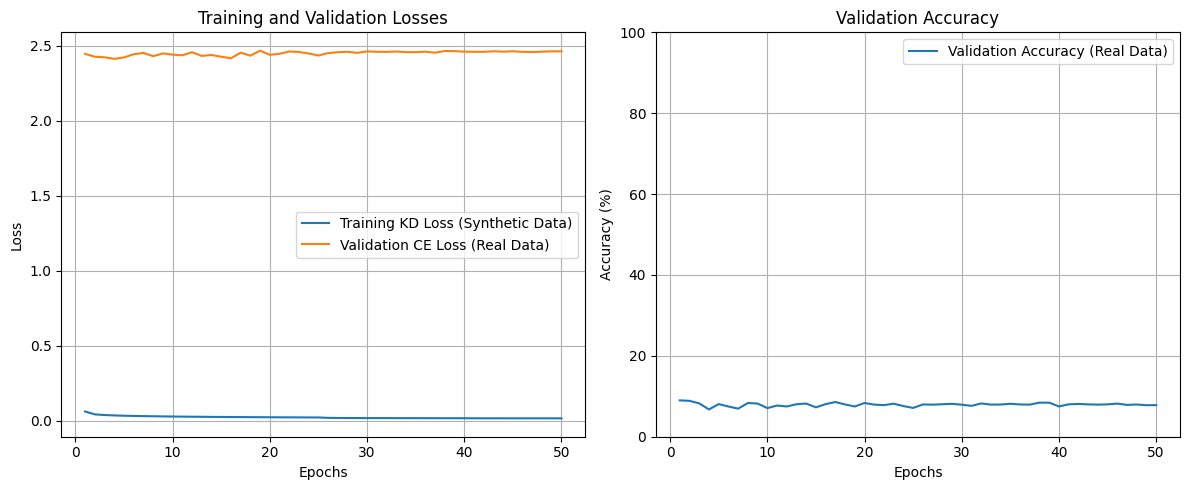


Step 7 Complete: Full training and evaluation finished.


In [17]:
# Step 7: Run Full Training and Evaluation

# --- Re-initialize Student Model and Optimizer ---
print("Re-initializing Student Model and Optimizer for full training run...")
student_model = models.resnet18(weights=None, num_classes=NUM_CLASSES_CIFAR10).to(DEVICE)
optimizer_student = optim.SGD(
    student_model.parameters(),
    lr=LEARNING_RATE_STUDENT,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler_student = optim.lr_scheduler.MultiStepLR(
    optimizer_student,
    milestones=[25, 40],
    gamma=0.1
)

# --- Training Loop ---
print(f"\nStarting full training for {EPOCHS_STUDENT} epochs..."

train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(1, EPOCHS_STUDENT + 1):
    print(f"\n--- Epoch {epoch}/{EPOCHS_STUDENT} ---")
    
    # Train student for one epoch
    epoch_train_loss = train_student_epoch(
        student_model,
        teacher_model,
        synthetic_train_loader,
        optimizer_student,
        kd_criterion,
        DEVICE
    )
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch} - Training Loss: {epoch_train_loss:.4f}")

    # Validate student
    epoch_val_loss, epoch_val_accuracy = validate_student_model(
        student_model,
        real_cifar10_test_loader,
        classification_criterion,
        DEVICE
    )
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    print(f"Epoch {epoch} - Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy*100:.2f}%")

    # Update learning rate
    scheduler_student.step()
    current_lr = optimizer_student.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")

    # Save the best model (based on validation accuracy)
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        print(f"*** New best validation accuracy: {best_val_accuracy*100:.2f}% (model checkpoint would be saved here) ***")

print("\n--- Training Complete ---")
print(f"Best Validation Accuracy achieved: {best_val_accuracy*100:.2f}%")

# --- Plotting Training Progress ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS_STUDENT + 1), train_losses, label='Training KD Loss (Synthetic Data)')
plt.plot(range(1, EPOCHS_STUDENT + 1), val_losses, label='Validation CE Loss (Real Data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS_STUDENT + 1), [acc * 100 for acc in val_accuracies], label='Validation Accuracy (Real Data)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

print("\nStep 7 Complete: Full training and evaluation finished.")

Re-initializing Student Model and Optimizer for full training run...

Starting full training for 50 epochs...

--- Epoch 1/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1 - Training Loss: 2.6914


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1 - Validation Loss: 2.4387, Validation Accuracy: 41.09%
Current Learning Rate: 0.050000
*** New best validation accuracy: 41.09% (model checkpoint would be saved here) ***

--- Epoch 2/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2 - Training Loss: 1.6621


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2 - Validation Loss: 1.9408, Validation Accuracy: 49.60%
Current Learning Rate: 0.050000
*** New best validation accuracy: 49.60% (model checkpoint would be saved here) ***

--- Epoch 3/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3 - Training Loss: 1.3432


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3 - Validation Loss: 1.6207, Validation Accuracy: 54.09%
Current Learning Rate: 0.050000
*** New best validation accuracy: 54.09% (model checkpoint would be saved here) ***

--- Epoch 4/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4 - Training Loss: 1.1689


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4 - Validation Loss: 1.4470, Validation Accuracy: 58.03%
Current Learning Rate: 0.050000
*** New best validation accuracy: 58.03% (model checkpoint would be saved here) ***

--- Epoch 5/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5 - Training Loss: 1.0252


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5 - Validation Loss: 1.2584, Validation Accuracy: 61.92%
Current Learning Rate: 0.050000
*** New best validation accuracy: 61.92% (model checkpoint would be saved here) ***

--- Epoch 6/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6 - Training Loss: 0.9957


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6 - Validation Loss: 1.3666, Validation Accuracy: 60.30%
Current Learning Rate: 0.050000

--- Epoch 7/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7 - Training Loss: 0.9302


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7 - Validation Loss: 1.0868, Validation Accuracy: 65.79%
Current Learning Rate: 0.050000
*** New best validation accuracy: 65.79% (model checkpoint would be saved here) ***

--- Epoch 8/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8 - Training Loss: 0.8998


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8 - Validation Loss: 1.2752, Validation Accuracy: 62.44%
Current Learning Rate: 0.050000

--- Epoch 9/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9 - Training Loss: 0.8509


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9 - Validation Loss: 1.1122, Validation Accuracy: 65.89%
Current Learning Rate: 0.050000
*** New best validation accuracy: 65.89% (model checkpoint would be saved here) ***

--- Epoch 10/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10 - Training Loss: 0.8026


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10 - Validation Loss: 0.9997, Validation Accuracy: 68.93%
Current Learning Rate: 0.050000
*** New best validation accuracy: 68.93% (model checkpoint would be saved here) ***

--- Epoch 11/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 11 - Training Loss: 0.8037


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11 - Validation Loss: 1.1768, Validation Accuracy: 65.00%
Current Learning Rate: 0.050000

--- Epoch 12/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 12 - Training Loss: 0.8130


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12 - Validation Loss: 1.0274, Validation Accuracy: 68.72%
Current Learning Rate: 0.050000

--- Epoch 13/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 13 - Training Loss: 0.7810


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13 - Validation Loss: 0.9772, Validation Accuracy: 69.65%
Current Learning Rate: 0.050000
*** New best validation accuracy: 69.65% (model checkpoint would be saved here) ***

--- Epoch 14/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 14 - Training Loss: 0.7486


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14 - Validation Loss: 1.1424, Validation Accuracy: 65.87%
Current Learning Rate: 0.050000

--- Epoch 15/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 15 - Training Loss: 0.7433


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15 - Validation Loss: 1.0358, Validation Accuracy: 67.73%
Current Learning Rate: 0.050000

--- Epoch 16/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 16 - Training Loss: 0.7170


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16 - Validation Loss: 0.9635, Validation Accuracy: 69.73%
Current Learning Rate: 0.050000
*** New best validation accuracy: 69.73% (model checkpoint would be saved here) ***

--- Epoch 17/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 17 - Training Loss: 0.7377


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17 - Validation Loss: 1.2300, Validation Accuracy: 63.02%
Current Learning Rate: 0.050000

--- Epoch 18/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 18 - Training Loss: 0.7629


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18 - Validation Loss: 1.0544, Validation Accuracy: 68.35%
Current Learning Rate: 0.050000

--- Epoch 19/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 19 - Training Loss: 0.7025


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19 - Validation Loss: 1.0178, Validation Accuracy: 68.34%
Current Learning Rate: 0.050000

--- Epoch 20/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 20 - Training Loss: 0.7176


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20 - Validation Loss: 1.0579, Validation Accuracy: 68.24%
Current Learning Rate: 0.050000

--- Epoch 21/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 21 - Training Loss: 0.7278


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21 - Validation Loss: 0.9622, Validation Accuracy: 69.33%
Current Learning Rate: 0.050000

--- Epoch 22/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 22 - Training Loss: 0.7039


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22 - Validation Loss: 1.0708, Validation Accuracy: 67.72%
Current Learning Rate: 0.050000

--- Epoch 23/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 23 - Training Loss: 0.6822


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23 - Validation Loss: 0.8933, Validation Accuracy: 71.36%
Current Learning Rate: 0.050000
*** New best validation accuracy: 71.36% (model checkpoint would be saved here) ***

--- Epoch 24/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 24 - Training Loss: 0.7176


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24 - Validation Loss: 0.9412, Validation Accuracy: 70.14%
Current Learning Rate: 0.050000

--- Epoch 25/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 25 - Training Loss: 0.6879


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25 - Validation Loss: 0.9198, Validation Accuracy: 70.57%
Current Learning Rate: 0.005000

--- Epoch 26/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 26 - Training Loss: 0.5052


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26 - Validation Loss: 0.7772, Validation Accuracy: 75.00%
Current Learning Rate: 0.005000
*** New best validation accuracy: 75.00% (model checkpoint would be saved here) ***

--- Epoch 27/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 27 - Training Loss: 0.4587


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27 - Validation Loss: 0.7675, Validation Accuracy: 75.31%
Current Learning Rate: 0.005000
*** New best validation accuracy: 75.31% (model checkpoint would be saved here) ***

--- Epoch 28/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 28 - Training Loss: 0.4328


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28 - Validation Loss: 0.7559, Validation Accuracy: 75.74%
Current Learning Rate: 0.005000
*** New best validation accuracy: 75.74% (model checkpoint would be saved here) ***

--- Epoch 29/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 29 - Training Loss: 0.4337


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29 - Validation Loss: 0.7305, Validation Accuracy: 76.79%
Current Learning Rate: 0.005000
*** New best validation accuracy: 76.79% (model checkpoint would be saved here) ***

--- Epoch 30/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 30 - Training Loss: 0.4358


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 30 - Validation Loss: 0.7535, Validation Accuracy: 75.43%
Current Learning Rate: 0.005000

--- Epoch 31/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 31 - Training Loss: 0.4144


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 31 - Validation Loss: 0.7245, Validation Accuracy: 76.34%
Current Learning Rate: 0.005000

--- Epoch 32/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 32 - Training Loss: 0.4176


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 32 - Validation Loss: 0.7275, Validation Accuracy: 76.32%
Current Learning Rate: 0.005000

--- Epoch 33/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 33 - Training Loss: 0.4158


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 33 - Validation Loss: 0.7169, Validation Accuracy: 77.09%
Current Learning Rate: 0.005000
*** New best validation accuracy: 77.09% (model checkpoint would be saved here) ***

--- Epoch 34/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 34 - Training Loss: 0.4142


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 34 - Validation Loss: 0.7297, Validation Accuracy: 76.35%
Current Learning Rate: 0.005000

--- Epoch 35/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 35 - Training Loss: 0.3966


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 35 - Validation Loss: 0.7375, Validation Accuracy: 75.67%
Current Learning Rate: 0.005000

--- Epoch 36/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 36 - Training Loss: 0.4037


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 36 - Validation Loss: 0.7150, Validation Accuracy: 77.04%
Current Learning Rate: 0.005000

--- Epoch 37/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 37 - Training Loss: 0.3984


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 37 - Validation Loss: 0.7156, Validation Accuracy: 76.95%
Current Learning Rate: 0.005000

--- Epoch 38/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 38 - Training Loss: 0.3983


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 38 - Validation Loss: 0.7366, Validation Accuracy: 75.86%
Current Learning Rate: 0.005000

--- Epoch 39/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 39 - Training Loss: 0.3914


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 39 - Validation Loss: 0.7124, Validation Accuracy: 76.58%
Current Learning Rate: 0.005000

--- Epoch 40/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 40 - Training Loss: 0.3885


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 40 - Validation Loss: 0.7132, Validation Accuracy: 76.86%
Current Learning Rate: 0.000500

--- Epoch 41/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 41 - Training Loss: 0.3650


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 41 - Validation Loss: 0.6948, Validation Accuracy: 77.66%
Current Learning Rate: 0.000500
*** New best validation accuracy: 77.66% (model checkpoint would be saved here) ***

--- Epoch 42/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 42 - Training Loss: 0.3528


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 42 - Validation Loss: 0.6989, Validation Accuracy: 77.32%
Current Learning Rate: 0.000500

--- Epoch 43/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 43 - Training Loss: 0.3514


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 43 - Validation Loss: 0.6954, Validation Accuracy: 77.16%
Current Learning Rate: 0.000500

--- Epoch 44/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 44 - Training Loss: 0.3560


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 44 - Validation Loss: 0.6894, Validation Accuracy: 77.48%
Current Learning Rate: 0.000500

--- Epoch 45/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 45 - Training Loss: 0.3476


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 45 - Validation Loss: 0.6823, Validation Accuracy: 77.61%
Current Learning Rate: 0.000500

--- Epoch 46/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 46 - Training Loss: 0.3466


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 46 - Validation Loss: 0.6876, Validation Accuracy: 77.56%
Current Learning Rate: 0.000500

--- Epoch 47/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 47 - Training Loss: 0.3446


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 47 - Validation Loss: 0.6883, Validation Accuracy: 77.24%
Current Learning Rate: 0.000500

--- Epoch 48/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 48 - Training Loss: 0.3430


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 48 - Validation Loss: 0.6860, Validation Accuracy: 77.50%
Current Learning Rate: 0.000500

--- Epoch 49/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 49 - Training Loss: 0.3461


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 49 - Validation Loss: 0.6847, Validation Accuracy: 77.53%
Current Learning Rate: 0.000500

--- Epoch 50/50 ---


Training Epoch:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 50 - Training Loss: 0.3449


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 50 - Validation Loss: 0.6855, Validation Accuracy: 77.58%
Current Learning Rate: 0.000500

--- Training Complete ---
Best Validation Accuracy achieved: 77.66%


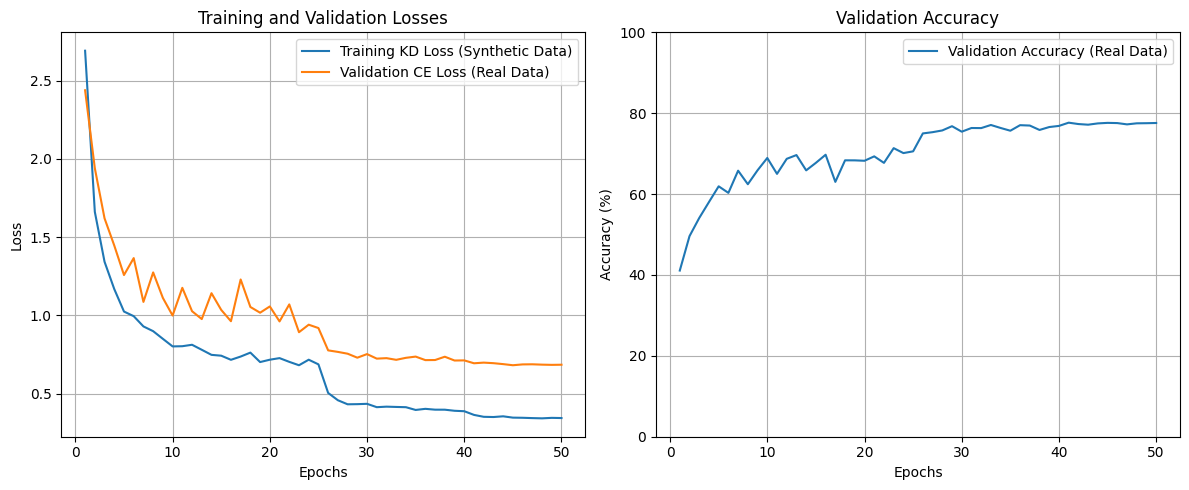


Step 7 Complete: Full training and evaluation finished.


In [13]:
# Step 7: Run Full Training and Evaluation

# --- Re-initialize Student Model and Optimizer ---
print("Re-initializing Student Model and Optimizer for full training run...")
student_model = models.resnet18(weights=None, num_classes=NUM_CLASSES_CIFAR10).to(DEVICE)
optimizer_student = optim.SGD(
    student_model.parameters(),
    lr=LEARNING_RATE_STUDENT,
    momentum=0.9,
    weight_decay=5e-4
)
scheduler_student = optim.lr_scheduler.MultiStepLR(
    optimizer_student,
    milestones=[25, 40],
    gamma=0.1
)

# --- Training Loop ---
print(f"\nStarting full training for {EPOCHS_STUDENT} epochs...")

train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0

for epoch in range(1, EPOCHS_STUDENT + 1):
    print(f"\n--- Epoch {epoch}/{EPOCHS_STUDENT} ---")
    
    # Train student for one epoch
    epoch_train_loss = train_student_epoch(
        student_model,
        teacher_model_finetuned,
        synthetic_train_loader,
        optimizer_student,
        kd_criterion,
        DEVICE
    )
    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch} - Training Loss: {epoch_train_loss:.4f}")

    # Validate student
    epoch_val_loss, epoch_val_accuracy = validate_student_model(
        student_model,
        real_cifar10_test_loader,
        classification_criterion,
        DEVICE
    )
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    print(f"Epoch {epoch} - Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy*100:.2f}%")

    # Update learning rate
    scheduler_student.step()
    current_lr = optimizer_student.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")

    # Save the best model (based on validation accuracy)
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        print(f"*** New best validation accuracy: {best_val_accuracy*100:.2f}% (model checkpoint would be saved here) ***")

print("\n--- Training Complete ---")
print(f"Best Validation Accuracy achieved: {best_val_accuracy*100:.2f}%")

# --- Plotting Training Progress ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS_STUDENT + 1), train_losses, label='Training KD Loss (Synthetic Data)')
plt.plot(range(1, EPOCHS_STUDENT + 1), val_losses, label='Validation CE Loss (Real Data)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS_STUDENT + 1), [acc * 100 for acc in val_accuracies], label='Validation Accuracy (Real Data)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

print("\nStep 7 Complete: Full training and evaluation finished.")